In [1]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage
)
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

model = ChatOpenAI(model='gpt-4o-mini')

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    '당신은 훌륭한 3단락 에세이를 작성하는 임무를 가진 에세이 어시스턴트입니다.'
    '사용자의 요청에 맞춰 최상의 에세이를 작성하세요.'
    '사용자가 비평을 제공하며, 이전 시도에 대한 수정 버전을 응답하세요.'
)

reflection_prompt = SystemMessage(
    '당신은 에세이 제출물을 평가하는 교사입니다. 사용자의 제출물에 대해 비평과 추천을 생성하세요.'
    '길이, 깊이, 스타일 등과 같은 구체적인 요구사항을 포함한 자세한 추천을 제공하세요.'
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state['messages'])
    return {'messages': [answer]}

def reflection(state: State) -> State:
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    translated = [reflection_prompt, state['messages'][0]] + [
        cls_map[msg.__class__](content=msg.content) for msg in state['messages'][1:]
    ]
    answer = model.invoke(translated)
    
    return {'messages': [HumanMessage(content=answer.content)]}


def should_continue(state: State):
    if len(state['messages']) > 6:
        return END
    return 'reflect'


builder = StateGraph(State)
builder.add_node('generate', generate)
builder.add_node('reflect', reflection)
builder.add_edge(START, 'generate')
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

graph = builder.compile()

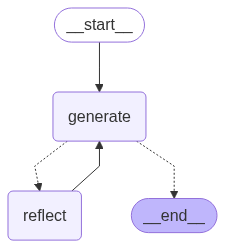

In [2]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))